In [1]:
! pip install -q tensorflow==2.4.1 tensorflow-quantum

     |████████████████████████████████| 394.3 MB 5.0 kB/s 
     |████████████████████████████████| 7.8 MB 41.9 MB/s 
     |████████████████████████████████| 462 kB 78.1 MB/s 
     |████████████████████████████████| 2.9 MB 73.9 MB/s 
     |████████████████████████████████| 3.8 MB 65.9 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 1.3 MB 77.8 MB/s 
     |████████████████████████████████| 90 kB 11.3 MB/s 
     |████████████████████████████████| 100 kB 12.2 MB/s 
     |████████████████████████████████| 5.6 MB 69.9 MB/s 
     |████████████████████████████████| 1.5 MB 60.4 MB/s 
     |████████████████████████████████| 380 kB 65.6 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |███████████████████

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import sympy
import numpy as np
import seaborn as sns

import collections
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from statsmodels.tsa.api import ExponentialSmoothing

model_type = []
global model_type



def update_model_type(var):
    model_type.append(var)

sample = []
global sample



def update_sample(var):
    sample.append(var)





/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
df = pd.read_csv("viable_dataset.csv", index_col="Date")

In [5]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
test_split = int((split_fraction+0.15) * int(df.shape[0]))
learning_rate = 0.001
batch_size = 1
epochs = 100

def quantum_rescale(dataset):
    x = dataset[[0,1,2,3,5]]
    y = dataset[[4]]

    x = x/(x.to_numpy().max())
    y = y/(y.to_numpy().max())
    return x, y

def smooth(dataset, train_split, smooth_level):
  for column in dataset.columns:
    data = dataset[column]
    exp = ExponentialSmoothing(data[:train_split])
    exp_model = exp.fit(smoothing_level=smooth_level)
    result = exp_model.fittedvalues
    dataset[column][:train_split] = result
    return dataset

class UndefinedQModelError(Exception):
    """Please input either 'discrete' or 'time-window' as model type"""
    def __init__(self, message="Please input either 'discrete' or 'time-window' as model type and specify number of inputs"):
        self.message = message
        super().__init__(self.message)
    pass

In [6]:
cols = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
selected_features = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
features = df[selected_features]
features.set_index(df.index, inplace=True)
#print(features.head())

features = smooth(features, train_split, smooth_level=0.8)
#print(features.head())

#features = normalize(features.values, train_split)
features = pd.DataFrame(features.values)
#print(features.head())




/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
X, y = quantum_rescale(features)


In [8]:
def create_discrete_circuits(data, qubits, test=False):
    cs = []
    column_list = [0,1,2,3,5]
    #print(data.iloc[4])
    for i in range(0,len(data)):
        
        cir = cirq.Circuit()

        for j in column_list:
            #print(f"i: {i} and j: {j}")
            if j==5:
              cir += cirq.rx(data.iloc[i][j] * np.pi).on(qubits[j-1])
              #print("Debug 1")
              cir += cirq.ry(data.iloc[i][j] * np.pi).on(qubits[j-1])
            else:
              cir += cirq.rx(data.iloc[i][j] * np.pi).on(qubits[j])
              #print("Debug 2")
              cir += cirq.ry(data.iloc[i][j] * np.pi).on(qubits[j])
        cs.append(cir)
    SVGCircuit(cir)
    if test:
        return tfq.convert_to_tensor([cs])
    return tfq.convert_to_tensor(cs)

def encode_discrete_data(data, labels, qubits):
    X_train =  data.iloc[:train_split-1]# 80:10:10 Split
    y_train = labels.iloc[:train_split-1]
    X_test =  data.iloc[train_split:test_split-1]
    y_test = labels.iloc[train_split:test_split-1]
    X_val =  data.iloc[test_split:]
    y_val = labels.iloc[test_split:]
    
    return create_discrete_circuits(X_train, qubits), create_discrete_circuits(X_val,qubits), create_discrete_circuits(X_test, qubits), y_train, y_val, y_test

In [9]:
# Quantum NN
def create_time_window_circuits(data, qubits, test=False):
    cs = []
    column_list = [0,1,2,3,5]
    #print(data.iloc[4])
    for i in range(0,len(data)-2):
        
        cir = cirq.Circuit()

        for j in column_list:
            #print(f"i: {i} and j: {j}")
            if j==5:
              cir += cirq.rx(data.iloc[i][j] * np.pi).on(qubits[j-1])
              #print("Hello1-5")
              cir += cirq.ry(data.iloc[i][j] * np.pi).on(qubits[j-1])
            else:
              cir += cirq.rx(data.iloc[i][j] * np.pi).on(qubits[j])
              #print("Hello1")
              cir += cirq.ry(data.iloc[i][j] * np.pi).on(qubits[j])

        for j in column_list:
            if j==5:
              cir += cirq.rx(data.iloc[i+1][j] * np.pi).on(qubits[j-1])
              #print("Hello2-5")
              cir += cirq.ry(data.iloc[i+1][j] * np.pi).on(qubits[j-1])

            else:
              cir += cirq.rx(data.iloc[i+1][j] * np.pi).on(qubits[j])
              #print("Hello2")
              cir += cirq.ry(data.iloc[i+1][j] * np.pi).on(qubits[j])

        for j in column_list:
            if j==5:
              cir += cirq.rx(data.iloc[i+2][j] * np.pi).on(qubits[j-1])
              #print("Hello3-5")
              cir += cirq.ry(data.iloc[i+2][j] * np.pi).on(qubits[j-1])
            else:
                cir += cirq.rx(data.iloc[i+2][j] * np.pi).on(qubits[j])
                #print("Hello3")
                cir += cirq.ry(data.iloc[i+2][j] * np.pi).on(qubits[j])
        
        cs.append(cir)
        SVGCircuit(cir)

    #print(cs[0])
    if test:
        return tfq.convert_to_tensor([cs])
    return tfq.convert_to_tensor(cs)

def encode_time_window_data(data, labels, qubits):

    X_train =  data.iloc[:train_split-1]# 80:10:10 Split
    y_train = labels.iloc[2:train_split-1]
    X_val =  data.iloc[test_split:]
    y_val = labels.iloc[test_split+2:]
    X_test =  data.iloc[train_split:test_split-1]
    y_test = labels.iloc[train_split+2:test_split-1]
    
    return create_time_window_circuits(X_train, qubits), create_time_window_circuits(X_val,qubits), create_time_window_circuits(X_test, qubits), y_train, y_val, y_test

In [10]:
#QCNN Layers were proposed by Cong and Lukin https://arxiv.org/abs/1810.03787
# Unitaries used were proposed by Robert Tucci https://arxiv.org/abs/quant-ph/0507171
# QCNN Layer implementation was demonstrated in https://www.tensorflow.org/quantum/tutorials/qcnn#15_define_layers
# These layers have been used to make multivariate QCNN regression models fort this project.
def one_qubit_unitary(bit, symbols):
        return cirq.Circuit(
            cirq.X(bit)**symbols[0],
            cirq.Y(bit)**symbols[1],
            cirq.Z(bit)**symbols[2])

def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

def quantum_conv_circuit(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit


In [11]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')

    model_circuit += quantum_conv_circuit(qubits, symbols[:15])# 15
    model_circuit += quantum_pool_circuit(qubits[:1], qubits[1:],# 6
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[1:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[1:3], qubits[3:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[3:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[3]], [qubits[4]],
                                          symbols[57:63])
    return model_circuit

In [12]:
def prepare_quantum_states(X, y, feature_count = 5, type=None):
  qubits = [cirq.GridQubit(0, i) for i in range(feature_count)]

  if type=='discrete':
    X_train, X_val, X_test, y_train, y_val, y_test = encode_discrete_data(X, y, qubits)
  elif type=='time-window':
    X_train, X_val, X_test, y_train, y_val, y_test = encode_time_window_data(X, y, qubits)
  else:
    raise UndefinedQModelError
  qcnn_circuit = create_model_circuit(qubits)
  print(qcnn_circuit)

  return qcnn_circuit, qubits, X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
def get_callbacks(patience = 5):
  path_checkpoint = "model_checkpoint.h5"
  es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=patience)

  modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
  )

  return es_callback, modelckpt_callback

In [14]:
def build_model(qcnn_circuit, qubits):

  readout_operators = [cirq.Z(qubits[0])]
  inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
  dense = tfq.layers.PQC(qcnn_circuit, readout_operators, differentiator=tfq.differentiators.Adjoint())(inputs)
  model = tf.keras.models.Model(inputs=inputs, outputs=dense)
  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3))

  return model

In [17]:
def make_q_cnn_model(type = None, retrain = False, model = None, history=None):
  update_model_type(type)
  qcnn_circuit, qubits, X_train, X_val, X_test, y_train, y_val, y_test = prepare_quantum_states(X, y, feature_count = 5, type=type)
  es_callback, modelckpt_callback = get_callbacks(patience = 5)

  if not retrain:
    model= build_model(qcnn_circuit, qubits)
  return train_model(model, es_callback, modelckpt_callback, X_train, X_val, y_train, y_val)

In [18]:
def train_model(model, es_callback, modelckpt_callback, X_train, X_val, y_train, y_val):
  history = model.fit(
    X_train, y_train ,
    epochs=100,
    batch_size=1,
    validation_data=(X_val, y_val),
    callbacks=[es_callback, modelckpt_callback]
    )
  return model, history

In [29]:
model, history = make_q_cnn_model('time-window',True, model, history)

(0, 0): ───X^qconv0───Y^qconv1───Z^qconv2────────────────────────────────────ZZ──────────YY──────────XX──────────X^qconv9───Y^qconv10───Z^qconv11──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv18───Y^qconv19───Z^qconv20───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

KeyboardInterrupt: ignored

In [37]:
model, history = make_q_cnn_model('discrete', False, model, history)

(0, 0): ───X^qconv0───Y^qconv1───Z^qconv2────────────────────────────────────ZZ──────────YY──────────XX──────────X^qconv9───Y^qconv10───Z^qconv11──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv18───Y^qconv19───Z^qconv20───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

KeyboardInterrupt: ignored

# **Quantum Model Validator**

In [ ]:
model_type[-1]

'time-window'

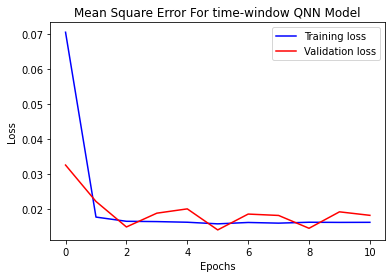

In [20]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, f"Mean Square Error For {model_type[-1]} QNN Model")

In [41]:
metrics = pd.DataFrame(columns=["TYPE", "sample", "MAPE",
                                "Accuracy%", "RMSE", "RMSE%", "MAE", "MAE%"])

update_sample('out_of_sample')
qcnn_circuit, qubits, X_train, X_val, X_test, y_train, y_val, y_test = prepare_quantum_states(X, y, feature_count = 5, type=model_type[-1])

actual = np.array(y_test).flatten() #* y.to_numpy().max()#Rescaling back to original values
predicted = model.predict(X_test).flatten() #* y.to_numpy().max()#Resclaing back to original values
errors = actual - predicted
# OUT OF SAMPLE

plt.clf()

results = pd.DataFrame(columns=["Expected", "Predicted"])
results["Expected"] = actual
results["Predicted"] = predicted
sns.set(rc={'figure.figsize':(12.7,6.27)})
sns.lineplot(data=results,palette="deep").set_title(sample[-1]
                                                    +"_quantum_"
                                                    +model_type[-1]
                                                    +"_cnn_forecast")
plt.savefig(sample[-1]+"_quantum_"+model_type[-1]+"_cnn_forecast"+ ".png")

results = pd.DataFrame(columns=["Expected", "Predicted"])
results["Expected"] = actual


results["Predicted"] = predicted

sns.set(rc={'figure.figsize':(12.7,6.27)})


sns.lineplot(data=results,palette="deep")


plt.clf()


errors = np.array(errors)
mape = np.mean(np.abs(errors)/actual)
rmse = np.sqrt(np.mean((np.square(errors))))
rmse_percent = 100*rmse/np.mean(actual)
mae = np.mean(np.abs(errors))
mae_percent = 100*np.mean(np.abs(errors))/np.mean(actual)
accuracy = 100 - 100*mape



metrics = metrics.append({"type":model_type[-1], "sample":sample[-1],
                          "MAPE": mape, "Accuracy%": accuracy, 
                          "RMSE":rmse, "RMSE%":rmse_percent,
                          "MAE":mae, "MAE%":mae_percent}, ignore_index=True )

(0, 0): ───X^qconv0───Y^qconv1───Z^qconv2────────────────────────────────────ZZ──────────YY──────────XX──────────X^qconv9───Y^qconv10───Z^qconv11──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv18───Y^qconv19───Z^qconv20───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

<Figure size 914.4x451.44 with 0 Axes>

In [42]:
metrics = pd.DataFrame(columns=["TYPE", "sample", "MAPE",
                                "Accuracy%", "RMSE", "RMSE%", "MAE", "MAE%"])

update_sample('in_sample')
qcnn_circuit, qubits, X_train, X_val, X_test, y_train, y_val, y_test = prepare_quantum_states(X, y, feature_count = 5, type=model_type[-1])

actual = np.array(y_val).flatten() #* y.to_numpy().max()#Rescaling back to original values
predicted = model.predict(X_val).flatten()# * y.to_numpy().max()#Resclaing back to original values
errors = actual - predicted
# IN SAMPLE

plt.clf()

results = pd.DataFrame(columns=["Expected", "Predicted"])
results["Expected"] = actual
results["Predicted"] = predicted
sns.set(rc={'figure.figsize':(12.7,6.27)})
sns.lineplot(data=results,palette="deep").set_title(sample[-1]
                                                    +"_quantum_"
                                                    +model_type[-1]
                                                    +"_cnn_forecast")
plt.savefig(sample[-1]+"_quantum_"+model_type[-1]+"_cnn_forecast"+ ".png")

results = pd.DataFrame(columns=["Expected", "Predicted"])
results["Expected"] = actual


results["Predicted"] = predicted

sns.set(rc={'figure.figsize':(12.7,6.27)})


sns.lineplot(data=results,palette="deep")


plt.clf()


errors = np.array(errors)
mape = np.mean(np.abs(errors)/actual)
rmse = np.sqrt(np.mean((np.square(errors))))
rmse_percent = 100*rmse/np.mean(actual)
mae = np.mean(np.abs(errors))
mae_percent = 100*np.mean(np.abs(errors))/np.mean(actual)
accuracy = 100 - 100*mape



metrics = metrics.append({"type":model_type[-1], "sample":sample[-1],
                          "MAPE": mape, "Accuracy%": accuracy, 
                          "RMSE":rmse, "RMSE%":rmse_percent,
                          "MAE":mae, "MAE%":mae_percent}, ignore_index=True )
metrics.to_csv("quantum_cnn_"+model_type[-1]+".csv")

(0, 0): ───X^qconv0───Y^qconv1───Z^qconv2────────────────────────────────────ZZ──────────YY──────────XX──────────X^qconv9───Y^qconv10───Z^qconv11──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv18───Y^qconv19───Z^qconv20───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

<Figure size 914.4x451.44 with 0 Axes>

In [43]:
model.save_weights("quantum_"+model_type[-1]+"_CNN_model")